In [2]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
print(torch.__version__)

2.5.1+cpu


In [4]:
# Imports here
import os            
import json         
import argparse     

import torch                  
from torch import nn, optim   
from torchvision import models, datasets, transforms  
from torch.utils.data import DataLoader 
import numpy as np        
from PIL import Image     

import matplotlib.pyplot as plt  
from collections import OrderedDict 

In [6]:
data_dir = ''
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  
        transforms.RandomHorizontalFlip(),  
        transforms.ToTensor(),              
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),           
        transforms.CenterCrop(224),        
        transforms.ToTensor(),              
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),             
        transforms.CenterCrop(224),       
        transforms.ToTensor(),            
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
    ]),
}
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test']),
}
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=64, shuffle=True),
    'valid': DataLoader(image_datasets['valid'], batch_size=64, shuffle=False),
    'test': DataLoader(image_datasets['test'], batch_size=64, shuffle=False),
}

In [9]:
import json
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [11]:
model = models.vgg16(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False

C:\Users\Hor\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Hor\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
from torch import nn
classifier = nn.Sequential(
    nn.Linear(25088, 1024),  
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 102),  
    nn.LogSoftmax(dim=1)  
)
model.classifier = classifier

In [13]:
from torch import optim
criterion = nn.NLLLoss()  
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [28]:
import time
epochs = 5
steps = 0
print_every = 50
running_loss = 0

scaler = torch.cuda.amp.GradScaler() if device == 'cuda' else None

start_time = time.time()  

for epoch in range(epochs):
    model.train()  
    for inputs, labels in dataloaders['train']:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        if scaler:
            with torch.cuda.amp.autocast():
                log_ps = model(inputs)
                loss = criterion(log_ps, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            log_ps = model(inputs)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            model.eval()  
            val_loss = 0
            accuracy = 0

            with torch.no_grad(): 
                for inputs, labels in dataloaders['valid']:
                    inputs, labels = inputs.to(device), labels.to(device)
                    log_ps = model(inputs)
                    batch_loss = criterion(log_ps, labels)
                    val_loss += batch_loss.item()

                    # Calculate accuracy
                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {val_loss/len(dataloaders['valid']):.3f}.. "
                  f"Validation accuracy: {accuracy/len(dataloaders['valid']):.3f}")

            running_loss = 0
            model.train() 

print(f"Total training time: {time.time() - start_time:.2f} seconds")

Epoch 1/5.. Train loss: 0.961.. Validation loss: 0.563.. Validation accuracy: 0.865
Epoch 1/5.. Train loss: 0.956.. Validation loss: 0.493.. Validation accuracy: 0.855
Epoch 2/5.. Train loss: 0.883.. Validation loss: 0.518.. Validation accuracy: 0.859
Epoch 2/5.. Train loss: 0.826.. Validation loss: 0.476.. Validation accuracy: 0.872
Epoch 3/5.. Train loss: 0.763.. Validation loss: 0.450.. Validation accuracy: 0.886
Epoch 3/5.. Train loss: 0.801.. Validation loss: 0.453.. Validation accuracy: 0.877
Epoch 4/5.. Train loss: 0.740.. Validation loss: 0.444.. Validation accuracy: 0.878
Epoch 4/5.. Train loss: 0.695.. Validation loss: 0.420.. Validation accuracy: 0.891
Epoch 5/5.. Train loss: 0.702.. Validation loss: 0.434.. Validation accuracy: 0.882
Epoch 5/5.. Train loss: 0.680.. Validation loss: 0.448.. Validation accuracy: 0.882
Total training time: 7268.39 seconds


In [29]:
checkpoint = {
    'model_state_dict': model.state_dict(),
    'classifier': model.classifier,
    'class_to_idx': image_datasets['train'].class_to_idx,
    'optimizer_state_dict': optimizer.state_dict(),
    'epochs': epochs
}
torch.save(checkpoint, 'checkpoint.pth')

In [30]:
model.eval()
test_loss = 0
accuracy = 0
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        log_ps = model(inputs)
        test_loss += criterion(log_ps, labels).item()
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test loss: {test_loss/len(dataloaders['test']):.3f}.. "
      f"Test accuracy: {accuracy/len(dataloaders['test']):.3f}")

Test loss: 0.492.. Test accuracy: 0.869


In [36]:
model.eval()
test_loss = 0
accuracy = 0
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        
        log_ps = model(inputs)
        
        batch_loss = criterion(log_ps, labels)
        test_loss += batch_loss.item()
       
        ps = torch.exp(log_ps) 
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape) 
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test Loss: {test_loss/len(dataloaders['test']):.3f}")
print(f"Test Accuracy: {accuracy/len(dataloaders['test']):.3f}")

Test Loss: 0.492
Test Accuracy: 0.869


In [55]:
hidden_units = 1024
model.class_to_idx = image_datasets['train'].class_to_idx
checkpoint = {
    'model_arch': 'vgg16', 
    'state_dict': model.state_dict(),  
    'class_to_idx': model.class_to_idx,
    'optimizer_state': optimizer.state_dict(), 
    'hidden_units': hidden_units, 
    'epochs': epochs 
}

torch.save(checkpoint, 'checkpoint.pth')
print("Checkpoint saved successfully!")

Checkpoint saved successfully!


In [61]:
checkpoint = torch.load('checkpoint.pth', weights_only=True)
print(checkpoint.keys())  
print(checkpoint['hidden_units']) 

dict_keys(['model_arch', 'state_dict', 'class_to_idx', 'optimizer_state', 'hidden_units', 'epochs'])
1024


In [67]:
print("Checkpoint state_dict keys:", checkpoint['state_dict'].keys())
print("Model state_dict keys:", model.state_dict().keys())

Checkpoint state_dict keys: odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])
Model state_dict keys: odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.

In [73]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location=torch.device('cpu'))
    model = models.__dict__[checkpoint['model_arch']](pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    
    hidden_units = checkpoint['hidden_units']
    model.classifier = nn.Sequential(
        nn.Linear(25088, hidden_units),  
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(hidden_units, 512),  
        nn.LogSoftmax(dim=1)
    )
    state_dict = checkpoint['state_dict']
    try:
        model.load_state_dict(state_dict, strict=False)
        print("Model loaded successfully with strict=False")
    except RuntimeError as e:
        print("Error loading state dict:", e)
        print("Detailed error:", e.args)
    
    model.class_to_idx = checkpoint['class_to_idx']
    return model

loaded_model = load_checkpoint('checkpoint.pth')

C:\Users\Hor\AppData\Local\Temp\ipykernel_20268\2921239907.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath, map_location=torch.device('c

Model loaded successfully with strict=False


In [138]:
def process_image(image):
    pil_image = Image.open("").convert('RGB')
    pil_image.thumbnail((256, 256)) 
    width, height = pil_image.size
    left = (width - 224) / 2
    top = (height - 224) / 2
    right = (width + 224) / 2
    bottom = (height + 224) / 2
    
    pil_image = pil_image.crop((left, top, right, bottom))
    np_image = np.array(pil_image) 
    
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]
    for i in range(3):
        np_image[..., i] = (np_image[..., i] - means[i]) / stds[i]
    np_image = np_image.transpose((2, 0, 1))
    return np_image

In [141]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    return ax

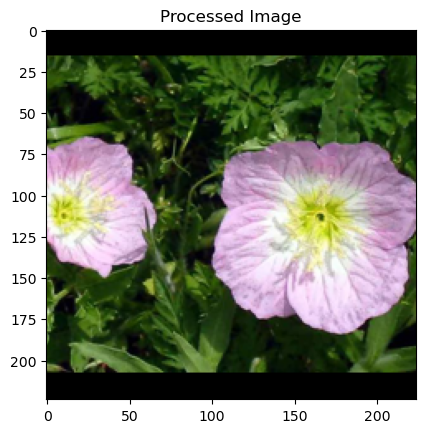

In [143]:
import torch
import matplotlib.pyplot as plt
image_tensor = torch.from_numpy(process_image('')).float()
imshow(image_tensor)
plt.title("Processed Image")
plt.show()

In [146]:
import torch.nn.functional as F
def predict(image_path, model, topk=5):
    image = process_image(image_path)  
    image_tensor = torch.from_numpy(image).unsqueeze(0).float()
    model.eval()
    
    with torch.no_grad():  
        output = model(image_tensor)
        
    probs = F.softmax(output, dim=1)
    top_probs, top_indices = probs.topk(topk, dim=1)
    top_probs = top_probs.squeeze().numpy() 
    top_indices = top_indices.squeeze().numpy()
    idx_to_class = {v: k for k, v in model.class_to_idx.items()}
    top_classes = [idx_to_class[idx] for idx in top_indices]
    
    return top_probs, top_classes

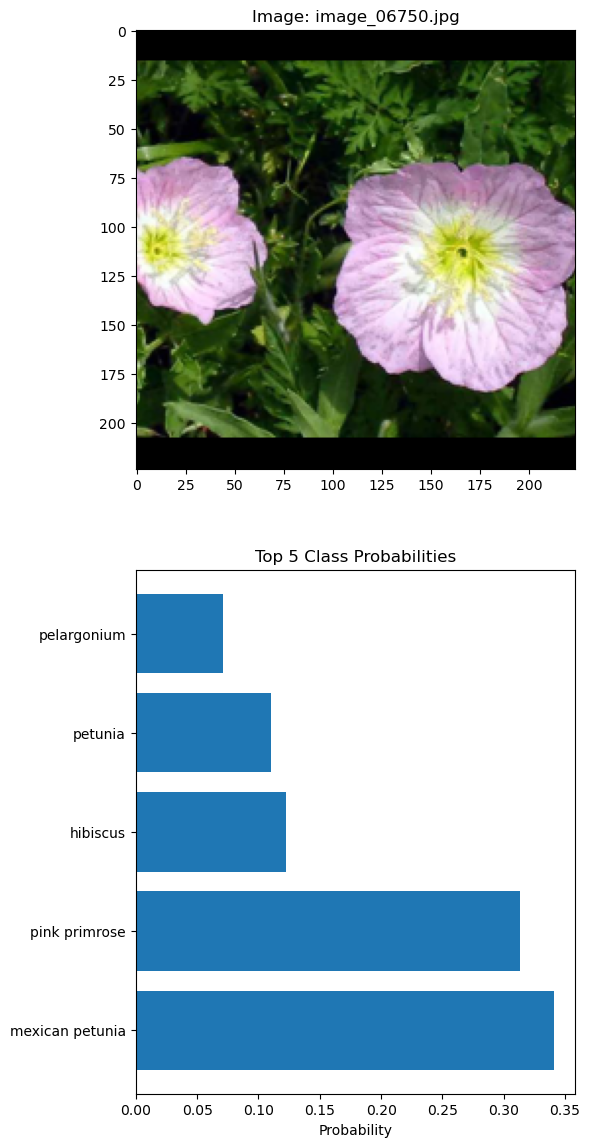

In [149]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def sanity_check(image_path, model, topk=5, cat_to_name=None):
    probs, classes = predict(image_path, model, topk)
    if cat_to_name:
        flower_names = [cat_to_name[str(cls)] for cls in classes]
    else:
        flower_names = classes 
    fig, (ax1, ax2) = plt.subplots(figsize=(6, 12), nrows=2, ncols=1)
    
    image = process_image(image_path)
    image_tensor = torch.from_numpy(image).unsqueeze(0).float()

    imshow(image_tensor.squeeze(0), ax=ax1) 
    ax1.set_title(f"Image: {image_path.split('/')[-1]}")
    ax2.barh(flower_names, probs)
    ax2.set_xlabel('Probability')
    ax2.set_title('Top 5 Class Probabilities')
    
    plt.tight_layout()
    plt.show()
image_path = ""

import json
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

sanity_check(image_path, model, topk=5, cat_to_name=cat_to_name)